In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim
import gym
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
env = gym.make('MountainCar-v0')

[2016-12-15 00:38:45,603] Making new env: MountainCar-v0


In [3]:
n_actions = env.action_space.n
n_features = env.observation_space.shape[0]

ANN to aproximate Q

In [4]:
class Approximator():
    ''' Neural network to approximate Q '''
    def __init__(self, n_features, hidden_size, n_actions, learning_rate=3e-4):
        # Placeholders
        self.X = tf.placeholder(name='input', dtype=tf.float32, shape=[None,n_features])
        self.Y = tf.placeholder(name='target', dtype=tf.float32, shape=[None])
        self.a = tf.placeholder(name='action', dtype=tf.int32, shape=[None])   

        # Network body
        self.hidden = slim.fully_connected(inputs=self.X, num_outputs=hidden_size, activation_fn=tf.nn.sigmoid)      
        self.Q = slim.fully_connected(inputs=self.hidden, num_outputs=n_actions, activation_fn=None)   

        # Loss
        # Get the value only for the chosen action
        self.batch_size = tf.shape(self.X)[0]
        self.actions_indices = tf.range(self.batch_size) * tf.shape(self.Q)[1] + self.a
        self.actions_value = tf.gather(tf.reshape(self.Q, [-1]), self.actions_indices)
        # Mean squared error
        self.losses = tf.squared_difference(self.Y, self.actions_value)
        self.loss = tf.reduce_mean(self.losses)
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate)
        # Compute and clip gradient
        self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
        self.clipped_grads = [(tf.clip_by_value(grad, -1, 1), var) for grad, var in self.grads_and_vars]
        self.train_op = self.optimizer.apply_gradients(self.clipped_grads)
    
    def predict(self, sess, state):
        ''' Feed foward the network to compute Q values '''
        return sess.run(self.Q, feed_dict={self.X:state})
    
    def update(self, sess, state, target, action):
        feed_dict = {self.X:state, self.Y:target, self.a:action}
        sess.run(self.train_op, feed_dict=feed_dict)           

In [5]:
def test_updates(n_updates=100, batch_size=100, learning_rate=1e-2):
    ''' Test if weights updates are affecting mostly the chosen action '''
    # Create a new graph
    tf.reset_default_graph()
    test = Approximator(n_features, hidden_size=8, n_actions=n_actions, learning_rate=learning_rate)
    states = [env.observation_space.sample() for _ in range(batch_size)]
    targets = 10 * np.ones(batch_size)
    for action in range(n_actions):
        Q_diff = []
        actions = action * np.ones(batch_size)
        # Reinitialize model for each action because ADAM optimizer builds momentum
        with tf.Session() as sess:
            tf.initialize_all_variables().run()
            for _ in range(n_updates):
                Q_old = np.mean(test.predict(sess, states), axis=0)
                test.update(sess, states, targets, actions)
                Q_new = np.mean(test.predict(sess, states), axis=0)
                Q_diff.append(Q_new - Q_old)
            print('Action {}: {}'.format(action, np.sum(Q_diff, axis=0)))

In [6]:
def epolicy(Q, epsilon=0.5):
    ''' Make an epsilon greedy choice'''    
    n_actions = len(np.squeeze(Q))
    A = (np.ones(n_actions) * epsilon) / n_actions
    best_action = np.argmax(np.squeeze(Q))
    A[best_action] += (1 - epsilon)    
    return A

In [7]:
def visualize(sess, Q):
    ''' Visualize Q function '''
    # Range of states
    pos = np.linspace(-1.2, 0.6, 100)
    vel = np.linspace(-0.07, 0.07, 100)        
    # Make a grid from states
    X, Y = np.meshgrid(pos, vel) # [100, 100], [100, 100]
    # Reshape to feed to the network
    X_flat, Y_flat = X.flatten(), Y.flatten()
    states = np.c_[X_flat, Y_flat] # [10000, 2]
    # Predict Q values
    Z = Q.predict(sess, states)
    # Get max Q values
    Z_max = np.max(Z, axis=1)
    Z_max = Z_max.reshape(X.shape)
    # Plot
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, -Z_max, cmap='jet')
    # Labels
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    # Camera angle
    ax.view_init(40, 55)
    plt.show()

In [8]:
test_updates()

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Action 0: [ 6.27786493 -0.10050249 -0.15947482]
Action 1: [ 0.15898427  6.95516253  0.29658034]
Action 2: [-0.2319681   0.04525405  6.43626499]


In [9]:
def train(n_episodes=500, learning_rate=4e-2, discount_factor=0.99, render=False, plot_Q=True):
    print('--- Started training ---')
    # Create network
    tf.reset_default_graph()
    Q_aprox = Approximator(n_features, 20, n_actions, learning_rate)
    
    # Store statistics
    ep_length = []    

    # Intialize tensorflow session
    with tf.Session() as sess:    
        tf.initialize_all_variables().run()

        for i_episode in range(n_episodes + 1):            
            # Exponentially decay epsilon
#             epsilon = 0.01 + (1 - 0.01) * np.exp(-1e-2 * i_episode)
            epsilon = 0.2

            # Reset state
            state = env.reset()
            # Pick first action
            Q = Q_aprox.predict(sess, [state])
            action_probs = epolicy(Q, epsilon)
            action = np.random.choice(np.arange(n_actions), p=action_probs)

            # Repeat until episode is finished
            for t in itertools.count():
                if render == True:
                    env.render()
                # Perform action
                next_state, reward, done, _ = env.step(action)

                # If terminal state target in only the reward
                if done:    
                    td_target = reward
                    # Update Q
                    Q_aprox.update(sess, [state], [td_target], [action])
                    break

                else:    
                    # Pick next action based on new state
                    Q_next = Q_aprox.predict(sess, [next_state])
                    action_probs_next = epolicy(Q_next, epsilon)
                    action_next = np.random.choice(np.arange(n_actions), p=action_probs_next)

                    # Calculate TD target
                    td_target = reward + discount_factor * Q_next[0][action_next]

                    # Update Q
                    Q_aprox.update(sess, [state], [td_target], [action])

                    # Update next state and action
                    state = next_state
                    action = action_next   

            # Store statistics         
            ep_length.append(t)
            # Print episode information
            print('\rEpisode: {}/{}'.format(i_episode, n_episodes), end=' | ', flush=True)
            print('Episode length: {}'.format(np.mean(ep_length[-1])), end='', flush=True)            
            if i_episode % 200 == 0:
                start = i_episode - 199
                end = i_episode + 1
                print('\rEpisode: {}/{}'.format(i_episode, n_episodes), end=' | ', flush=True)
                print('Average length: {}'.format(np.mean(ep_length[start:end])), end='', flush=True)
                if plot_Q:
                    visualize(sess, Q_aprox)
                
    return ep_length

--- Started training ---


/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode: 0/2000 | Average length: 9685.0

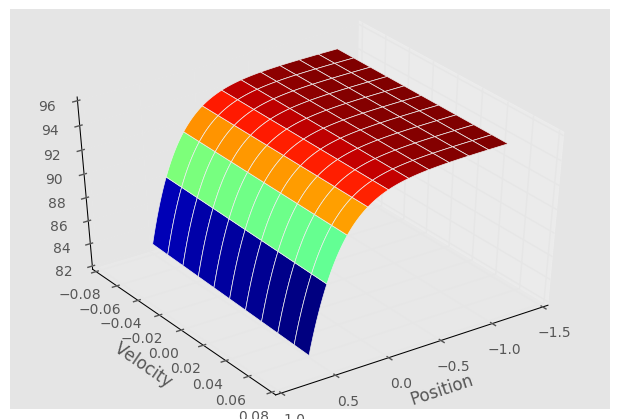

Episode: 200/2000 | Average length: 1393.91

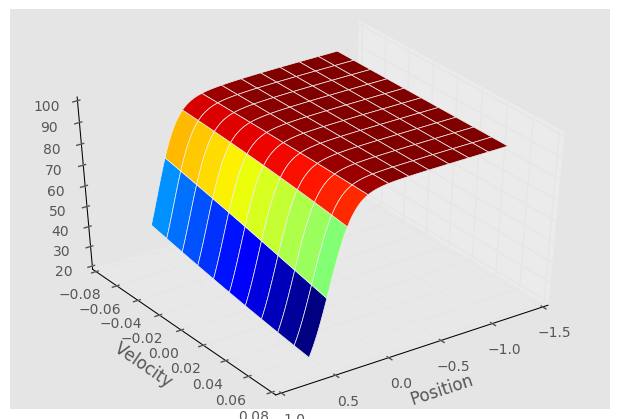

Episode: 400/2000 | Average length: 371.865

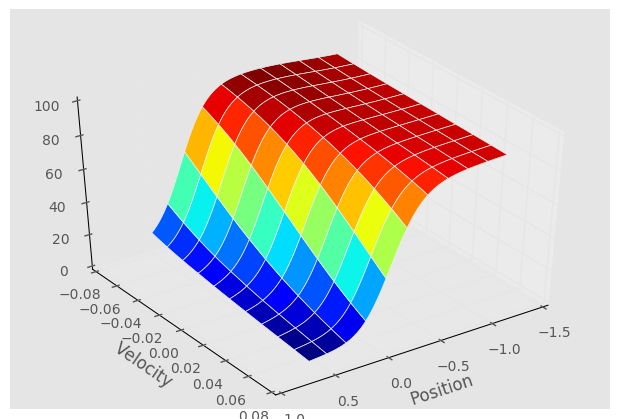

Episode: 600/2000 | Average length: 359.92

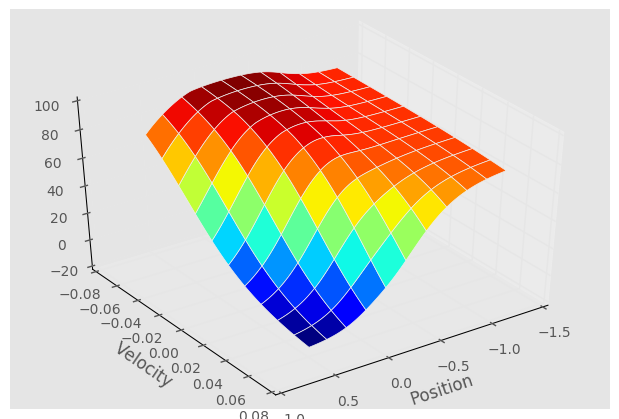

Episode: 800/2000 | Average length: 566.255

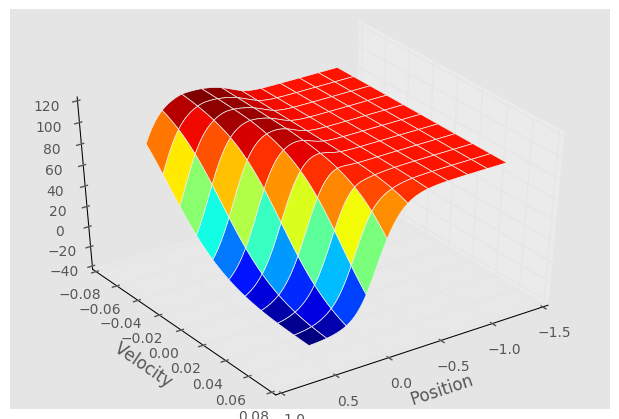

Episode: 1000/2000 | Average length: 284.635

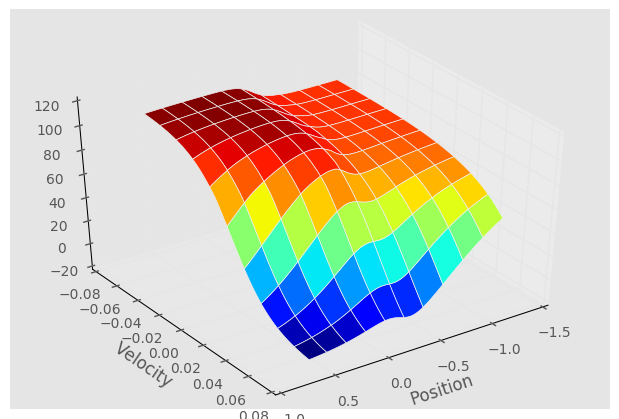

Episode: 1200/2000 | Average length: 201.33

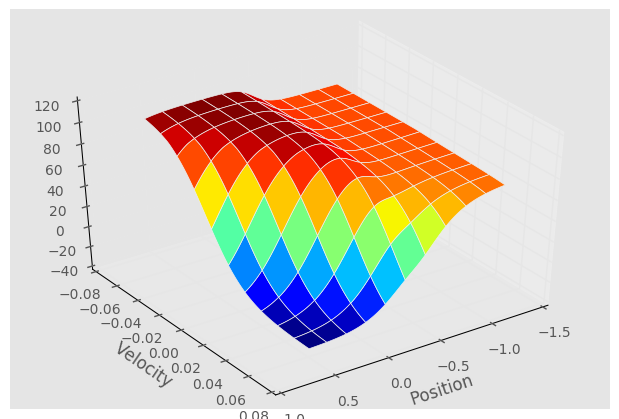

Episode: 1400/2000 | Average length: 170.635

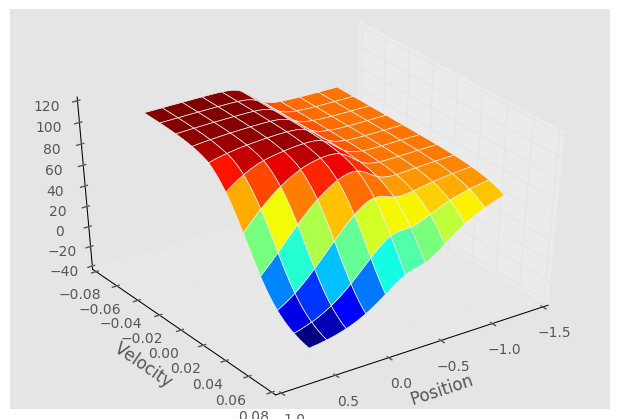

Episode: 1600/2000 | Average length: 166.555

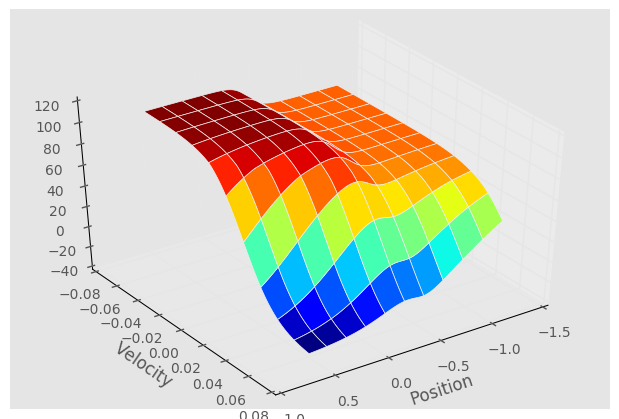

Episode: 1800/2000 | Average length: 559.88

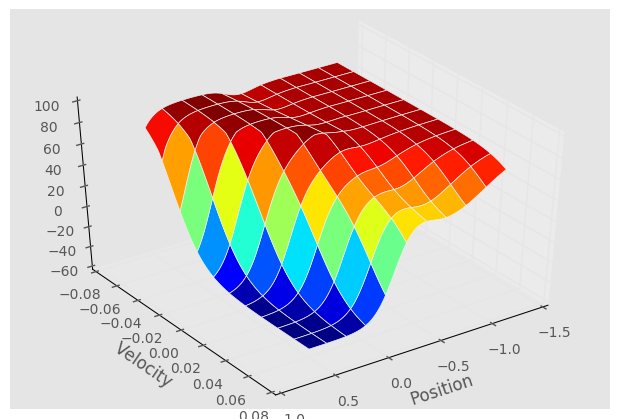

Episode: 2000/2000 | Average length: 182.43

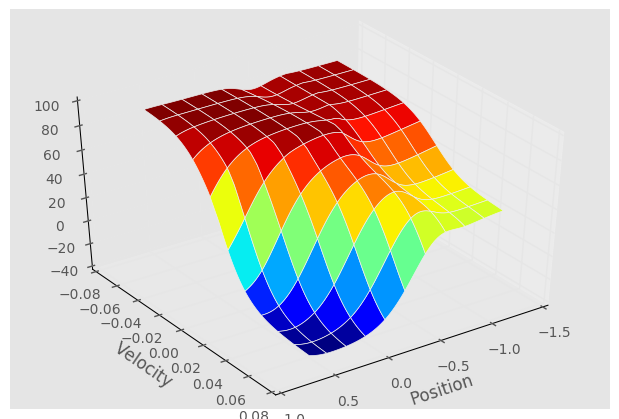

In [10]:
eps_length = train(n_episodes=2000, learning_rate=1e-3, plot_Q=True)

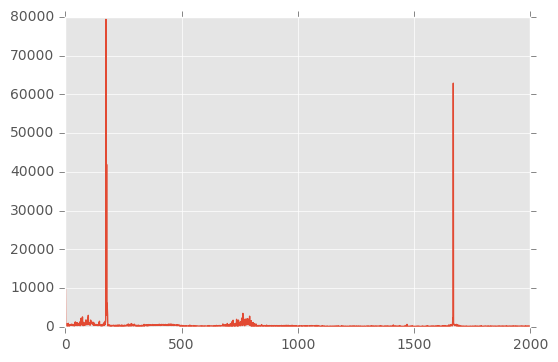

In [12]:
plt.plot(eps_length)